In [196]:
#================================================
# DATA
#================================================

import duckdb, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# creating the conection to the duckdb database file:
con = duckdb.connect("movielens100K.duckdb")

In [197]:
IMDB_DIR = Path("..") / "data" / "Imdb"
IMDB_DIR

WindowsPath('../data/Imdb')

### 1.0 Temporary Views to query Imdb File composition
#### 1.1 Creation of view with File "name.basics.tsv"

In [198]:
# Creating the view for the name.basics file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_name_basics AS
SELECT *
FROM read_csv_auto(
    '{IMDB_DIR / "name.basics.tsv"}',
    delim='\t',
    header=TRUE,
    nullstr='\\N'
)
""")


In [199]:
# Reviewing the structure of the imdb_name_basics table
con.sql("DESCRIBE imdb_name_basics").df()


,column_name,column_type,null,key,default,extra
0,nconst,VARCHAR,YES,None,None,None
1,primaryName,VARCHAR,YES,None,None,None
2,birthYear,BIGINT,YES,None,None,None
3,deathYear,BIGINT,YES,None,None,None
4,primaryProfession,VARCHAR,YES,None,None,None
5,knownForTitles,VARCHAR,YES,None,None,None


In [200]:
# Reviewing some data from the imdb_name_basics table
con.sql("SELECT * FROM imdb_name_basics LIMIT 3").df()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0027125,tt0025164"
1,nm0000002,Lauren Bacall,1924,2014,"actress,miscellaneous,soundtrack","tt0037382,tt0075213,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934,<NA>,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"


In [201]:
# count of the number of distinct professions in the table and diferent profissions in the dataset
professions_df=con.sql("""
        WITH all_professions AS (
        SELECT UNNEST(str_split(primaryProfession, ',')) AS profession 
        FROM imdb_name_basics
    ),
    count_professions AS (
        SELECT COUNT(DISTINCT profession) AS distinct_professions
        FROM all_professions
    ),
    professions_stats AS (
        SELECT profession,
        COUNT(*) AS total
    FROM all_professions
    GROUP BY profession
    ),
    union_table AS (
    
    SELECT
        'TOTAL_DISTINCT_PROFESSIONS' AS profession,
        (SELECT distinct_professions FROM count_professions) AS total
    UNION ALL
    SELECT
        profession,
        total
    FROM professions_stats
    )
    SELECT *
    FROM union_table
    ORDER BY
        CASE WHEN profession = 'TOTAL_DISTINCT_PROFESSIONS' THEN 0 ELSE 1 END,
        total DESC
    --LIMIT 15
 """).df()

professions_df

,profession,total
0,TOTAL_DISTINCT_PROFESSIONS,46
1,actor,3412934
2,actress,2062425
3,miscellaneous,1338806
4,producer,1309116
5,writer,981441
6,camera_department,870867
7,director,802905
8,art_department,486831
9,cinematographer,430325


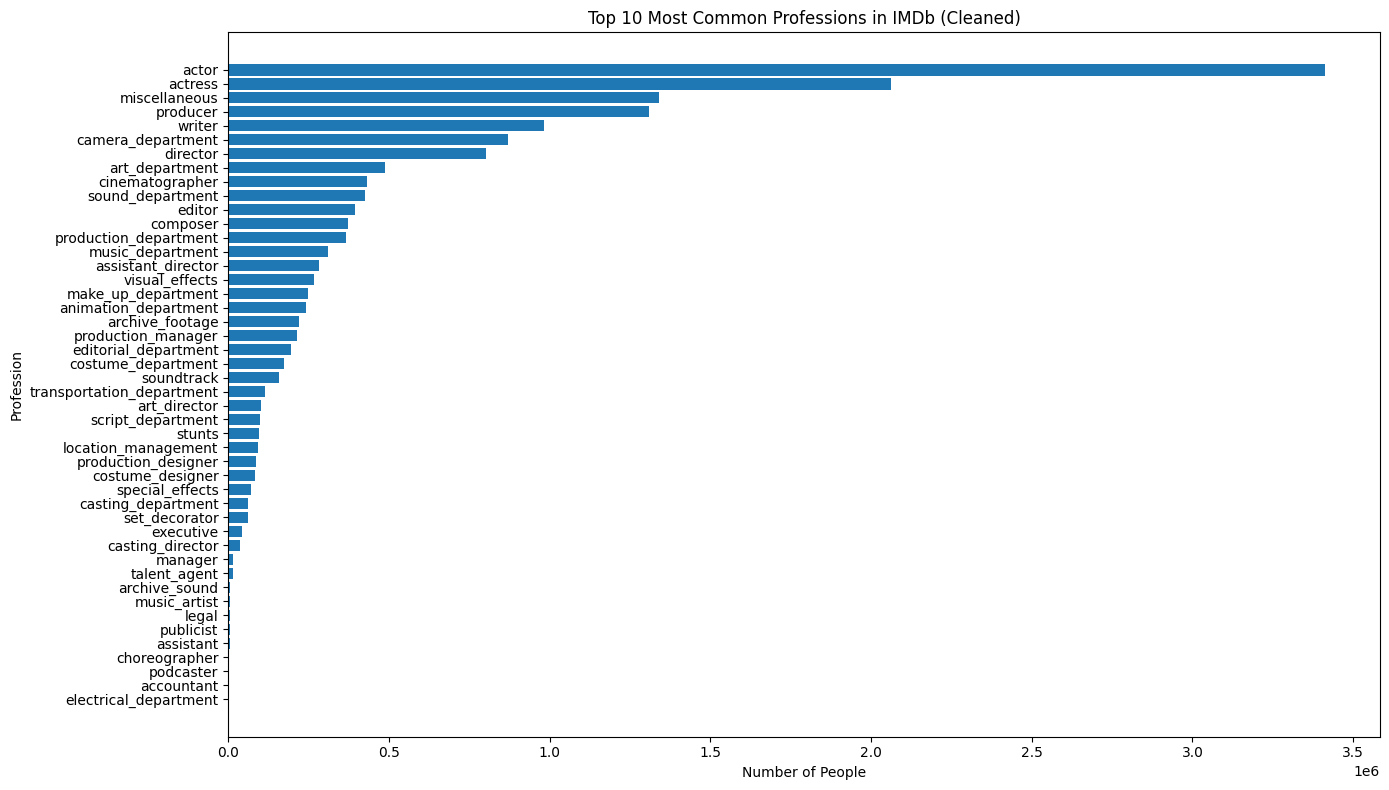

In [202]:
# Making a bar graph with query results

professions_df = professions_df.iloc[1:]

plt.figure(figsize=(14, 8))
plt.barh(professions_df["profession"], professions_df["total"])
plt.xlabel("Number of People")
plt.ylabel("Profession")
plt.title("Top 10 Most Common Professions in IMDb (Cleaned)")
plt.gca().invert_yaxis()  # Maior valor no topo
plt.tight_layout()
plt.show()

#### 1.2 Creation of view with File "title.basics.tsv"

In [203]:
# Creating the view for the title.basics file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_title_basics AS
SELECT *
FROM read_csv_auto(
    '{IMDB_DIR / "title.basics.tsv"}',
    delim='\t',
    header=TRUE,
    nullstr='\\N'
)
""")

In [204]:
# Reviewing the structure of the imdb_title_basics table
con.sql("describe imdb_title_basics").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,titleType,VARCHAR,YES,None,None,None
2,primaryTitle,VARCHAR,YES,None,None,None
3,originalTitle,VARCHAR,YES,None,None,None
4,isAdult,BIGINT,YES,None,None,None
5,startYear,BIGINT,YES,None,None,None
6,endYear,VARCHAR,YES,None,None,None
7,runtimeMinutes,BIGINT,YES,None,None,None
8,genres,VARCHAR,YES,None,None,None


In [205]:
# Reviewing some data from the imdb_title_basics table
con.sql("SELECT * FROM imdb_title_basics LIMIT 3").df()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,None,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,None,5,"Animation,Short"
2,tt0000003,short,Poor Pierrot,Pauvre Pierrot,0,1892,None,5,"Animation,Comedy,Romance"


In [206]:
# How many films does this Db has
con.sql("""
SELECT COUNT(DISTINCT tconst) AS total_titles
FROM imdb_title_basics
""").df()

,total_titles
0,12046631


#### 1.3 Creation of view with File "title.crew.tsv"

In [207]:
con.sql(f"""
CREATE OR REPLACE VIEW imdb_title_crew AS
SELECT *
FROM read_csv_auto(
    '{IMDB_DIR / "title.crew.tsv"}',
    delim='\t',
    header=TRUE,
    nullstr='\\N'
)
""")


In [208]:
# Reviewing the structure of the imdb_title_crew table
con.sql("DESCRIBE imdb_title_crew").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,directors,VARCHAR,YES,None,None,None
2,writers,VARCHAR,YES,None,None,None


In [209]:
# Reviewing some data from the imdb_title_crew table
con.sql("SELECT * FROM imdb_title_crew LIMIT 3").df()

,tconst,directors,writers
0,tt0000001,nm0005690,None
1,tt0000002,nm0721526,None
2,tt0000003,nm0721526,nm0721526


In [210]:
# How many diferent directors and writers this DB has
con.sql("""
SELECT COUNT(DISTINCT tconst) AS titles_count,COUNT(DISTINCT directors) AS directors_count, COUNT(DISTINCT writers) AS writers_count
FROM imdb_title_crew
""").df()

,titles_count,directors_count,writers_count
0,12048919,983104,1461632


Database with important information: Director and writer name by movie.

#### 1.4 Creation of view with File "title.principals.tsv"

In [211]:
# Creating the view for the principals file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_principals AS
SELECT *
FROM read_csv_auto(
    '{IMDB_DIR / "title.principals.tsv"}',
    delim='\t',
    header=TRUE,
    nullstr='\\N'
)
""")


In [212]:
# Reviewing the structure of the imdb_principals table
con.sql("DESCRIBE imdb_principals").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,ordering,BIGINT,YES,None,None,None
2,nconst,VARCHAR,YES,None,None,None
3,category,VARCHAR,YES,None,None,None
4,job,VARCHAR,YES,None,None,None
5,characters,VARCHAR,YES,None,None,None


In [213]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM imdb_principals LIMIT 5").df()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,None,"[""Self""]"
1,tt0000001,2,nm0005690,director,None,None
2,tt0000001,3,nm0005690,producer,producer,None
3,tt0000001,4,nm0374658,cinematographer,director of photography,None
4,tt0000002,1,nm0721526,director,None,None


In [214]:
# Count of the different categories and number of occurrences of each one
con.sql("""
SELECT category, COUNT(*) AS total
FROM imdb_principals
GROUP BY category
ORDER BY total DESC
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,category,total
0,actor,22719012
1,actress,17158284
2,self,14124424
3,writer,11435609
4,director,8212472
5,producer,7156896
6,editor,5053629
7,cinematographer,3863550
8,composer,3096612
9,production_designer,1141840


In [220]:
# Count of the different jobs and number of occurrences of each one
con.sql("""
SELECT job, COUNT(*) AS total
FROM imdb_principals
GROUP BY job
ORDER BY total DESC
LIMIT 30
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,job,total
0,None,77742195
1,producer,6982719
2,writer,1769000
3,director,874812
4,written by,750320
5,composer,595525
6,creator,586535
7,editor,584163
8,created by,572716
9,director of photography,550000


#### 1.5 Creation of view with File "title.ratings.tsv"

In [175]:
# Creating the view for the title.episode file
con.sql(f"""
CREATE OR REPLACE VIEW imdb_ratings AS
SELECT *
FROM read_csv_auto('{IMDB_DIR / "title.ratings.tsv"}', delim='\t', header=TRUE)
""")

In [176]:
# Reviewing the structure of the imdb_ratings table
con.sql("DESCRIBE imdb_ratings").df()

,column_name,column_type,null,key,default,extra
0,tconst,VARCHAR,YES,None,None,None
1,averageRating,DOUBLE,YES,None,None,None
2,numVotes,BIGINT,YES,None,None,None


In [177]:
# Reviewing some data from the imdb_ratings table
con.sql("SELECT * FROM imdb_ratings LIMIT 5").df()

,tconst,averageRating,numVotes
0,tt0000001,5.7,2183
1,tt0000002,5.5,304
2,tt0000003,6.4,2263
3,tt0000004,5.2,195
4,tt0000005,6.2,3006


In [221]:
# Some statistics about the ratings and votes
con.sql("""
SELECT
    COUNT(*)                        AS total_filmes,
    MIN(averageRating)              AS min_rating,
    MAX(averageRating)              AS max_rating,
    AVG(averageRating)              AS media_rating,
    MIN(numVotes)                   AS min_votes,
    MAX(numVotes)                   AS max_votes,
    AVG(numVotes)                   AS media_votes
FROM imdb_ratings
""").df()

,total_filmes,min_rating,max_rating,media_rating,min_votes,max_votes,media_votes
0,1634484,1.0,10.0,6.928612,5,3116740,1017.511738


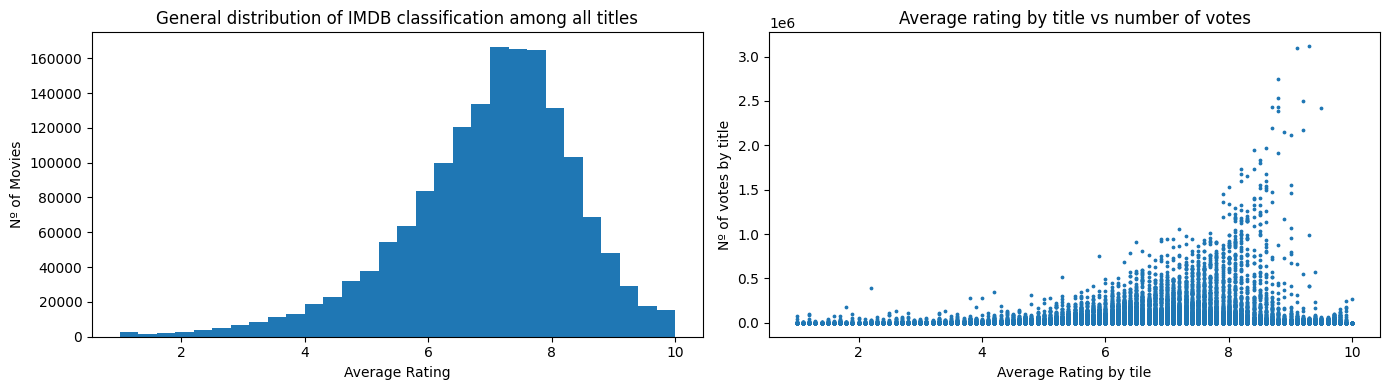

In [222]:
# Visualizing the distribution of ratings and votes
df_ratings = con.sql("SELECT averageRating FROM imdb_ratings").df()
df_votes   = con.sql("SELECT numVotes, averageRating FROM imdb_ratings WHERE numVotes < 50000000000").df()

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,4))

# --- gráfic 1: hist rating
axes[0].hist(df_ratings["averageRating"], bins=30)
axes[0].set_title("General distribution of IMDB classification among all titles")
axes[0].set_xlabel("Average Rating")
axes[0].set_ylabel("Nº of Movies")

# --- gráfico 2: scatter
axes[1].scatter(df_votes["averageRating"], df_votes["numVotes"], s=3)
axes[1].set_title("Average rating by title vs number of votes")
axes[1].set_xlabel("Average Rating by tile")
axes[1].set_ylabel("Nº of votes by title")

plt.tight_layout()
plt.show()


#### 1.6 Summary of Imdb info

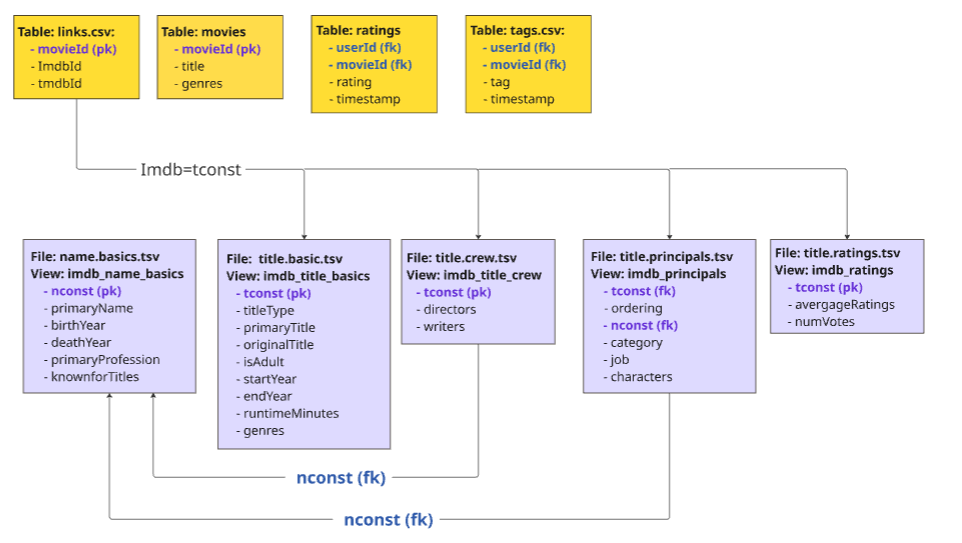

In [178]:
# List of all tables in the database
con.sql("""
SELECT table_name, table_type
FROM information_schema.tables
""").df()

,table_name,table_type
0,links,BASE TABLE
1,movielens_actors,BASE TABLE
2,movielens_directors,BASE TABLE
3,movielens_writers,BASE TABLE
4,movies,BASE TABLE
5,ratings,BASE TABLE
6,tags,BASE TABLE
7,imdb_map_ids,VIEW
8,imdb_name_basics,VIEW
9,imdb_principals,VIEW


### 2.0 Data enrichment with Imdb dataset
#### 2.1 Creation of table view with movies ID (imdb and movielens)

In [223]:
# Df Creation with link between movielens and Imdb links
con.sql("""
CREATE OR REPLACE VIEW imdb_map_ids AS
SELECT
    movieId,
    'tt' || LPAD(imdbId, 7, '0') AS tconst
FROM links
WHERE imdbId IS NOT NULL;
""")

In [224]:
# Reviewing some data from the imdbmaps_ids table
con.sql("SELECT * FROM imdb_map_ids LIMIT 10").df()

,movieId,tconst
0,1,tt0114709
1,2,tt0113497
2,3,tt0113228
3,4,tt0114885
4,5,tt0113041
5,6,tt0113277
6,7,tt0114319
7,8,tt0112302
8,9,tt0114576
9,10,tt0113189


In [225]:
# How many MovieLens movies have link to imdbId?
con.sql("""
SELECT COUNT(*) AS movielens_movies_count,
       COUNT(imdbId) AS movies_with_link,
       COUNT(*) - COUNT(imdbId) AS movies_without_link
FROM links
""").df()


,movielens_movies_count,movies_with_link,movies_without_link
0,86537,86537,0


#### 2.2 Creation of table with movielens movie directors

In [226]:
# Creation of table movielens_directors
con.sql("""
CREATE OR REPLACE TABLE movielens_directors AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName AS director_name
FROM movies AS m
JOIN imdb_map_ids AS map ON map.movieId = m.movieId
JOIN imdb_title_crew AS c ON c.tconst = map.tconst
-- explode comma-separated directors into rows
CROSS JOIN UNNEST(str_split(c.directors, ',')) AS d(director_nconst_raw)
LEFT JOIN imdb_name_basics AS nb
    ON nb.nconst = TRIM(d.director_nconst_raw)
WHERE c.directors IS NOT NULL
  AND c.directors <> '';
""")


In [227]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_directors LIMIT 5").df()

,movieId,title,director_name
0,262753,Arendelle Castle Yule Log (2020),Masakazu Oyamada
1,265448,Vertigo A.I. (2020),James Hawes
2,200988,The Agro Rebel: Permaculture in the Salzburg A...,Bertram Verhaag
3,64614,Gran Torino (2008),Clint Eastwood
4,130954,Guter Junge (2008),Torsten C. Fischer


In [228]:
# Query para determinar quantos fimes do nosso dataset original encontram aqui resposta para o seu director e quantos não encontrma
con.sql("""
WITH t AS (
    SELECT COUNT(*) AS total_movies FROM movies
),
d AS (
    SELECT COUNT(DISTINCT movieId) AS movies_with_director
    FROM movielens_directors
)
SELECT
    t.total_movies,
    d.movies_with_director,
    t.total_movies - d.movies_with_director AS movies_without_director
FROM t, d;
""").df()

,total_movies,movies_with_director,movies_without_director
0,86537,83360,3177


In [229]:
top_directors = con.sql("""
SELECT
    director_name,
    COUNT(*) AS total_movies
FROM movielens_directors
WHERE director_name IS NOT NULL
GROUP BY director_name
ORDER BY total_movies DESC
LIMIT 10;
""").df()

top_directors


,director_name,total_movies
0,Georges Méliès,116
1,Friz Freleng,111
2,Chuck Jones,108
3,Tex Avery,89
4,Michael Curtiz,84
5,Jean-Luc Godard,75
6,John Ford,73
7,Richard Thorpe,71
8,Jack Hannah,66
9,Jack Kinney,65


In [230]:
# Compute mean, median and mode of number of directors per film
con.sql("""
WITH director_counts AS (
    SELECT
        movieId,
        COUNT(*) AS num_directors
    FROM movielens_directors
    GROUP BY movieId
),
mode_calc AS (
    SELECT
        num_directors,
        COUNT(*) AS freq,
        ROW_NUMBER() OVER (ORDER BY COUNT(*) DESC) AS rn
    FROM director_counts
    GROUP BY num_directors
)
SELECT
    AVG(num_directors) AS mean_directors,
    MEDIAN(num_directors) AS median_directors,
    (SELECT num_directors FROM mode_calc WHERE rn = 1) AS mode_directors
FROM director_counts
        """).df()

,mean_directors,median_directors,mode_directors
0,1.148117,1.0,1


#### 2.3 Creation of table with movielens movie writers

In [231]:
# Creation of table movielens_writers
con.sql("""
CREATE OR REPLACE TABLE movielens_writers AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName AS writer_name
FROM movies AS m
JOIN imdb_map_ids AS map
    ON map.movieId = m.movieId
JOIN imdb_title_crew AS c
    ON c.tconst = map.tconst
CROSS JOIN UNNEST(str_split(c.writers, ',')) AS d(writer_nconst_raw)
LEFT JOIN imdb_name_basics AS nb
    ON nb.nconst = TRIM(d.writer_nconst_raw)
WHERE c.writers IS NOT NULL
  AND c.writers <> ''
  AND c.writers <> '\\N';
""")


In [232]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_writers LIMIT 5").df()

,movieId,title,writer_name
0,201292,Chocolate (2005),Mick Garris
1,196659,Dance of the Dead (2005),Richard Matheson
2,201318,Deer Woman (2005),John Landis
3,201262,Dreams in the Witch House (2005),Stuart Gordon
4,201294,Homecoming (2005),Dale Bailey


In [237]:
# Query to determine writers with more movies in the dataset
top_writers = con.sql("""
SELECT
    writer_name,
    COUNT(*) AS total_movies
FROM movielens_writers
WHERE writer_name IS NOT NULL
GROUP BY writer_name
ORDER BY total_movies DESC
LIMIT 10;
""").df()

top_writers


,writer_name,total_movies
0,William Shakespeare,153
1,Ben Hecht,114
2,Michael Maltese,98
3,Kuang Ni,89
4,Stephen King,83
5,Arthur Conan Doyle,77
6,Charles Chaplin,77
7,Furio Scarpelli,74
8,Ernesto Gastaldi,73
9,Piero De Bernardi,73


This table does not make sense. After visiting IMDB page is undertanded that there are several diferent writers but only one general wrting. 

link: https://www.imdb.com/title/tt0120762/fullcredits/?ref_=tt_ov_sm_2#amzn1.imdb.concept.name_credit_category.c84ecaff-add5-4f2e-81db-102a41881fe3
 

#### 2.4 Creation of table with movielens_actors

In [239]:
# Creation of Movielens_actors table
con.sql("""
CREATE OR REPLACE TABLE movielens_actors AS
SELECT
    m.movieId,
    m.title,
    nb.primaryName     AS actor_name,
    p.category,
    p.characters
FROM movies m
JOIN imdb_map_ids map ON map.movieId = m.movieId
JOIN imdb_principals p ON p.tconst = map.tconst
LEFT JOIN imdb_name_basics nb ON nb.nconst = p.nconst
WHERE p.category IN ('actor', 'actress');
""")

# removing characters [" e "]:
con.sql("""
UPDATE movielens_actors
SET characters = REGEXP_REPLACE(characters, '[\\[\\]\"]', '', 'g')
""")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [240]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_actors LIMIT 5").df()

,movieId,title,actor_name,category,characters
0,284289,Risto Vanari's Candid Camera (1979),Seija Ignatius,actress,None
1,284289,Risto Vanari's Candid Camera (1979),Susanne Olsson,actress,Miss Skandinavia
2,284289,Risto Vanari's Candid Camera (1979),Liisa Paatso,actress,Woman in car accident
3,284289,Risto Vanari's Candid Camera (1979),Kaija Pakarinen,actress,Abandoned bride
4,284289,Risto Vanari's Candid Camera (1979),Marjatta Raita,actress,Traffic investigator


In [246]:
top_actors = con.sql("""
SELECT
    actor_name,
    COUNT(*) AS total_movies
FROM movielens_actors
WHERE actor_name IS NOT NULL
GROUP BY actor_name
ORDER BY total_movies DESC
LIMIT 20;
""").df()

top_actors


,actor_name,total_movies
0,Mel Blanc,876
1,Clarence Nash,372
2,Pinto Colvig,270
3,Billy Bletcher,181
4,Frank Welker,168
5,Walt Disney,163
6,Eric Roberts,158
7,James MacDonald,155
8,Christopher Lee,151
9,Jeff Bennett,140


In [244]:
#Top 20 most common character names
con.sql("""
SELECT
    characters,
    COUNT(*) AS n_rows
FROM movielens_actors
GROUP BY characters
ORDER BY n_rows DESC
LIMIT 20;
""").df()

,characters,n_rows
0,None,26920
1,Narrator,2435
2,Anna,784
3,Sam,746
4,Paul,729
5,Doctor,708
6,David,703
7,Additional Voices,693
8,Frank,681
9,Jack,675


#### 2.5 Criação de tabela com avaliação os ratings e votos do imdb

In [247]:
# IMDb ratings mapped to MovieLens movieId
con.sql("""
CREATE OR REPLACE TABLE movielens_ratings_imdb AS
SELECT
    m.movieId,
    r.numVotes,
    r.averageRating
FROM movies m
JOIN imdb_map_ids map ON map.movieId = m.movieId
LEFT JOIN imdb_ratings r ON r.tconst = map.tconst
""")


In [248]:
# Reviewing some data from the imdb_principals table
con.sql("SELECT * FROM movielens_ratings_imdb LIMIT 5").df()

,movieId,numVotes,averageRating
0,194438,247,7.1
1,208639,2413,4.1
2,227831,1693,8.1
3,149380,2215,6.3
4,192561,42405,5.6


In [252]:
# Sample top by votes
con.sql("""
SELECT
    r.movieId,
    m.title,
    r.numVotes,
    r.averageRating
FROM movielens_ratings_imdb r
LEFT JOIN movies m
    ON r.movieId = m.movieId
WHERE r.numVotes IS NOT NULL
ORDER BY r.numVotes DESC
LIMIT 20;
""").df()


,movieId,title,numVotes,averageRating
0,318,"Shawshank Redemption, The (1994)",3116740,9.3
1,58559,"Dark Knight, The (2008)",3092751,9.1
2,79132,Inception (2010),2747491,8.8
3,2959,Fight Club (1999),2531591,8.8
4,356,Forrest Gump (1994),2434223,8.8
5,109487,Interstellar (2014),2426457,8.7
6,296,Pulp Fiction (1994),2381196,8.8
7,2571,"Matrix, The (1999)",2198642,8.7
8,858,"Godfather, The (1972)",2173294,9.2
9,4993,"Lord of the Rings: The Fellowship of the Ring,...",2152498,8.9


,table_name,table_type
0,links,BASE TABLE
1,movielens_actors,BASE TABLE
2,movielens_directors,BASE TABLE
3,movielens_ratings_imdb,BASE TABLE
4,movielens_writers,BASE TABLE
5,movies,BASE TABLE
6,ratings,BASE TABLE
7,tags,BASE TABLE
8,imdb_map_ids,VIEW
9,imdb_name_basics,VIEW


#### 2.6 Summary of new Tables info

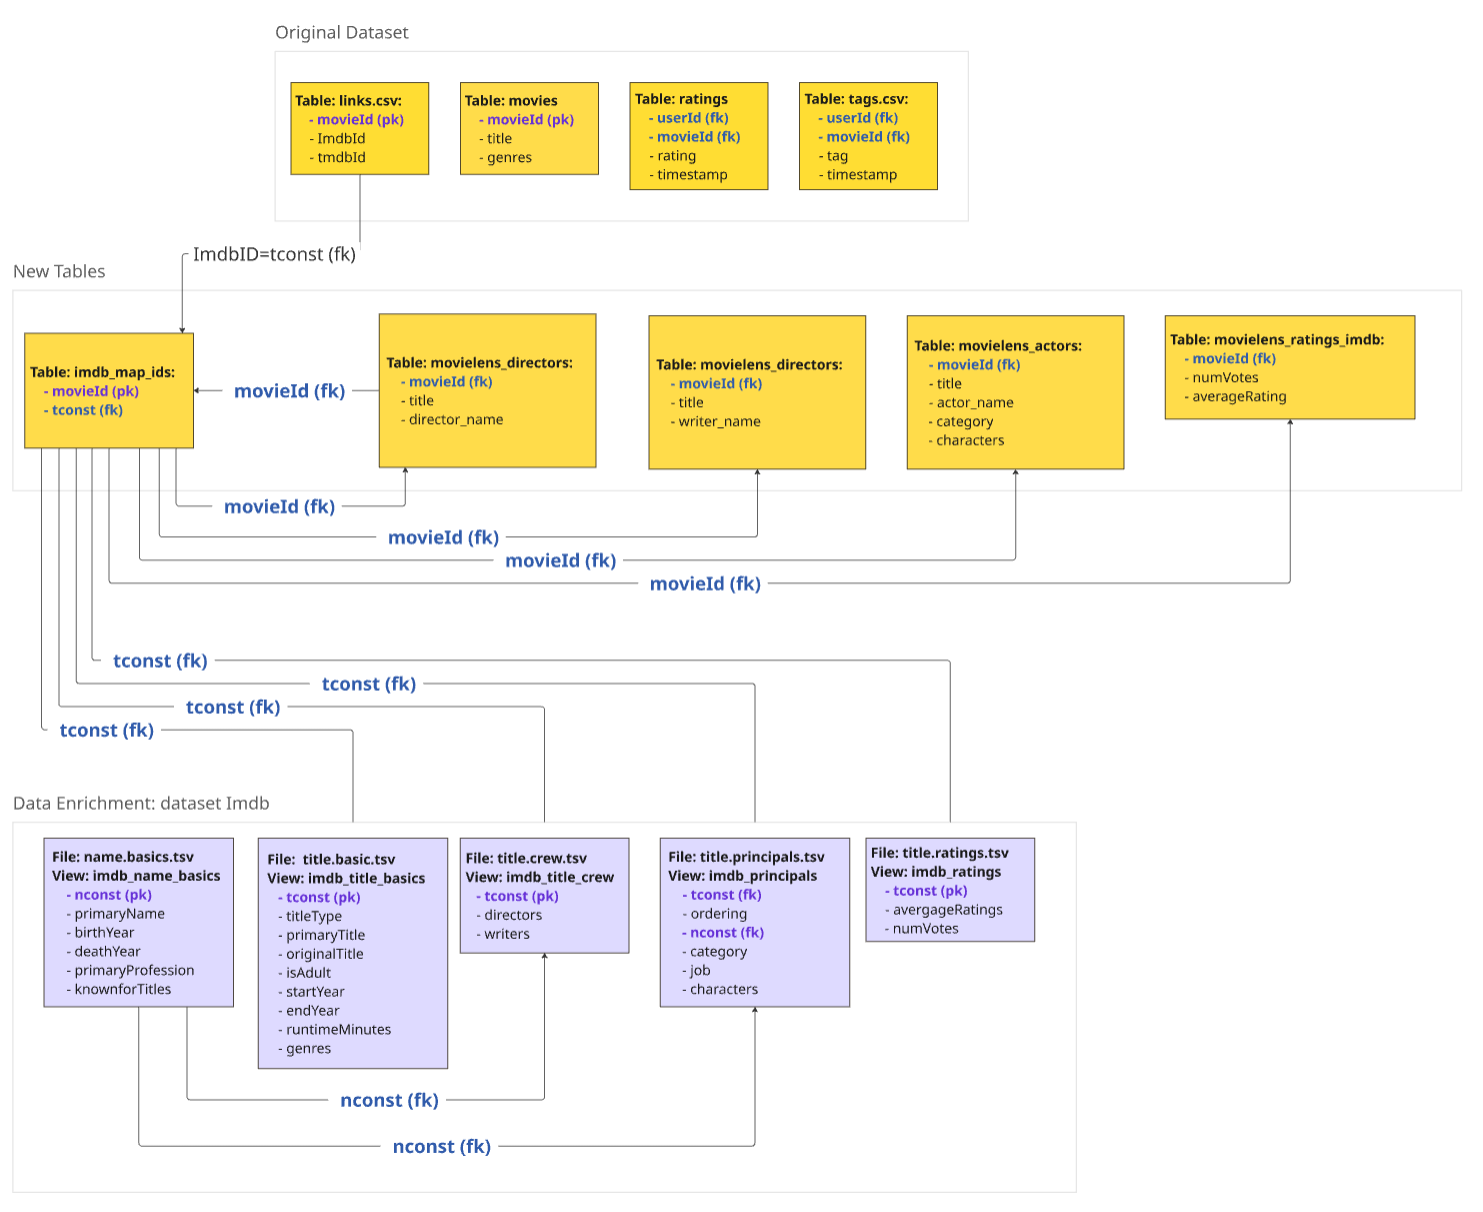

In [253]:
# List of all tables in the database
con.sql("""
SELECT table_name, table_type
FROM information_schema.tables
""").df()

,table_name,table_type
0,links,BASE TABLE
1,movielens_actors,BASE TABLE
2,movielens_directors,BASE TABLE
3,movielens_ratings_imdb,BASE TABLE
4,movielens_writers,BASE TABLE
5,movies,BASE TABLE
6,ratings,BASE TABLE
7,tags,BASE TABLE
8,imdb_map_ids,VIEW
9,imdb_name_basics,VIEW


#### Fechar a ligação

In [194]:
con.close()
print("Ligação fechada.")

Ligação fechada.
